In [183]:
import pyspark as ps
import pandas as pd
import pprint as pp
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.ticker import FuncFormatter, MaxNLocator
from pyspark import SparkContext
from pyspark.sql import Row
from pyspark.sql.types import TimestampType, BooleanType
from pyspark.sql.functions import hour, dayofmonth, size, udf
import json
import datetime
import numpy as np
from scipy.stats import chisquare
import time


spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("df lecture") \
            .getOrCreate()
sc=spark.sparkContext

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width', 2000)

In [2]:
dir_link = '/home/asus/Downloads/'
twitter_df = spark.read.json(dir_link + 'Tweets/data/french_tweets.json')


In [3]:
twitter_df.show()

+------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------+---------+------------+--------------------+------------------+------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+--------------------+------------------+--------------------+------------------+--------------------+-------------+---------+--------------------+--------------------+-------------+---------+--------------------+
|contributors|         coordinates|          created_at|display_text_range|            entities|   extended_entities|      extended_tweet|favorite_count|favorited|filter_level|                 geo|                id|            id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|limit|               place|possibly_s

In [133]:
schema = twitter_df.schema

In [129]:
twitter_df.printSchema()
schema = twitter_df.Schema

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |

AttributeError: 'DataFrame' object has no attribute 'Schema'

In [5]:
# Create a temporary table to run sql commands on
tweets = twitter_df.createOrReplaceTempView("tweets")

In [6]:
# create a pandas dataframe of the first 10 objects to see columns better
df_pandas = pd.DataFrame(twitter_df.head(10), columns=twitter_df.columns)
df_pandas

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,limit,place,possibly_sensitive,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,source,text,timestamp_ms,truncated,user
0,None,None,Wed Apr 26 13:30:45 +0000 2017,None,"([], None, [], [], [])",None,None,0,False,low,None,857225437122097152,857225437122097152,None,NaN,None,NaN,None,False,fr,None,"(([[[-0.061141, 49.208997], [-0.061141, 49.250115], [-0.032199, 49.250115], [-0.032199, 49.208997]]], Polygon), France, FR, Dozulé, France, 4da693e9b39923ab, Dozulé, city, https://api.twitter.com/1.1/geo/id/4da693e9b39923ab.json)",None,None,NaN,None,0,False,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Je comprends pas trop la fin de 13 reasons why 😓,1493213445345,False,"(False, Sun Apr 05 16:03:00 +0000 2015, True, False, None, 777, None, 318, None, 406, True, 3137428743, 3137428743, False, fr, 2, None, TAÏNA♡, None, C0DEED, http://abs.twimg.com/images/themes/theme1/bg.png, https://abs.twimg.com/images/themes/theme1/bg.png, False, https://pbs.twimg.com/profile_banners/3137428743/1492766586, http://pbs.twimg.com/profile_images/857204115981697024/XcetMiHe_normal.jpg, https://pbs.twimg.com/profile_images/857204115981697024/XcetMiHe_normal.jpg, 1DA1F2, C0DEED, DDEEF6, 333333, True, False, tainabmn, 3251, None, None, None, False)"
1,None,None,Wed Apr 26 13:30:45 +0000 2017,"[11, 48]","([], None, [], [], [(787617474820841472, 787617474820841472, [0, 10], jules moreaux, julesbl99)])",None,None,0,False,low,None,857225437088555009,857225437088555009,julesbl99,8.572209e+17,857220945982967808,7.876175e+17,787617474820841472,False,fr,None,"(([[[-1.663459, 47.239088], [-1.663459, 47.30961], [-1.576006, 47.30961], [-1.576006, 47.239088]]], Polygon), France, FR, Orvault, France, 09ef78b32799b6e8, Orvault, city, https://api.twitter.com/1.1/geo/id/09ef78b32799b6e8.json)",None,None,NaN,None,0,False,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@julesbl99 travailles au lieu de raconter ta vie,1493213445337,False,"(False, Tue Jun 24 23:16:43 +0000 2014, False, False, Les gens depensent dl'argent qu'ils ne gagnent pas pour acheter ds choses dont ils nont pas besoin pr impressionner des gens qu'ils n'aiment pas. snap: audran_6, 1015, None, 173, None, 134, True, 2586505687, 2586505687, False, fr, 1, None, Cerpyth, None, C0DEED, http://abs.twimg.com/images/themes/theme1/bg.png, https://abs.twimg.com/images/themes/theme1/bg.png, False, https://pbs.twimg.com/profile_banners/2586505687/1434792576, http://pbs.twimg.com/profile_images/675445019294212096/0d1ksXko_normal.jpg, https://pbs.twimg.com/profile_images/675445019294212096/0d1ksXko_normal.jpg, 0048B3, C0DEED, DDEEF6, 333333, True, False, Audran_6, 2922, None, None, None, False)"
2,None,None,Wed Apr 26 13:30:46 +0000 2017,"[25, 82]","([], None, [], [], [(326757541, 326757541, [0, 9], L'Echo Républicain, lecho_fr), (3482554756, 3482554756, [10, 24], La Saucelle Off, lasaucelleoff)])",None,None,0,False,low,None,857225441157021697,857225441157021697,lecho_fr,8.171161e+17,817116111389032448,3.267575e+08,326757541,False,fr,None,"(([[[1.427255, 48.421392], [1.427255, 48.446024], [1.478306, 48.446024], [1.478306, 48.421392]]], Polygon), France, FR, Lucé, France, 50d429c8224054f9, Lucé, city, https://api.twitter.com/1.1/geo/id/50d429c8224054f9.json)",None,None,NaN,None,0,False,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",@lecho_fr @lasaucelleoff J'espère faire mieux mais c'est pas sûr dieu seul le sait,1493213446307,False,"(False, Mon Dec 05 16:07:15 +0000 2016, False, False, Je reste discret sur ma vie comme ça pas de mensonge â vous dire. La photo vous dit la réponse pas compli

In [7]:
def failsafe_decode(row):
    try:
        return json.loads(row)
    except:
        return None

In [108]:
def format_timestamp(ts):
    ts = int(ts)
    ts = ts/1000
    return datetime.datetime.fromtimestamp(ts)

In [109]:
rdd = sc.textFile(dir_link + 'Tweets/data/french_tweets.json')

In [110]:
rdd = rdd.map(lambda x: failsafe_decode(x)).filter(lambda x: x!=None).cache()

214926


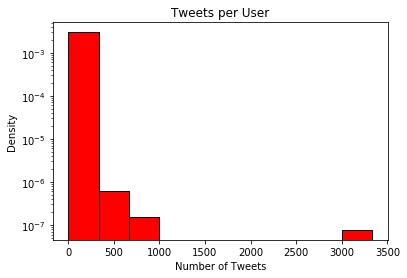

In [123]:
user_tweets = rdd.filter(lambda x:'user'  in x)\
    .filter(lambda x: 'name' in x['user']).cache()
print(user_tweets.count())
    
tweets_per_user = user_tweets.map(lambda x: (x['user']['name'], 1))\
    .reduceByKey(lambda x, y: x+y)\
    .map(lambda x: x[1])\
    .collect()

fig, ax = plt.subplots()
ax.hist(tweets_per_user, density=True, color='r', edgecolor='black')
ax.set_yscale('log')
ax.set_xlabel('Number of Tweets')
ax.set_ylabel('Density')
_ = ax.set_title("Tweets per User")

In [ ]:
def format_timestamp(ts):
    ts = int(ts)
    ts = ts/1000
    return datetime.datetime.fromtimestamp(ts)

In [178]:
def json_to_row(rdd):
    return Row(creation_date=datetime.strptime(rdd['created_at'], '%a %b %d %X %z %Y'),\
               hashtag_list=[y['text'].lower() if y['text'].lower() != 'tpmp' else 'tpmp1000' for y in rdd['entities']['hashtags'] ])

rdd_df = spark.createDataFrame(rdd, schema=schema)

In [179]:
rdd_df.take(5)

[Row(contributors=None, coordinates=None, created_at='Wed Apr 26 13:30:45 +0000 2017', display_text_range=None, entities=Row(hashtags=[], media=None, symbols=[], urls=[], user_mentions=[]), extended_entities=None, extended_tweet=None, favorite_count=0, favorited=False, filter_level='low', geo=None, id=857225437122097152, id_str='857225437122097152', in_reply_to_screen_name=None, in_reply_to_status_id=None, in_reply_to_status_id_str=None, in_reply_to_user_id=None, in_reply_to_user_id_str=None, is_quote_status=False, lang='fr', limit=None, place=Row(bounding_box=Row(coordinates=[[[-0.061141, 49.208997], [-0.061141, 49.250115], [-0.032199, 49.250115], [-0.032199, 49.208997]]], type='Polygon'), country='France', country_code='FR', full_name='Dozulé, France', id='4da693e9b39923ab', name='Dozulé', place_type='city', url='https://api.twitter.com/1.1/geo/id/4da693e9b39923ab.json'), possibly_sensitive=None, quoted_status=None, quoted_status_id=None, quoted_status_id_str=None, retweet_count=0, r

In [209]:
# fixed datetime within dataframe to proper date
func = udf(lambda x: datetime.datetime.fromtimestamp((int(x)/1000)), TimestampType())
df = rdd_df.withColumn('timestamp_ms', func(col('timestamp_ms')))
df.take(1)

[Row(contributors=None, coordinates=None, created_at='Wed Apr 26 13:30:45 +0000 2017', display_text_range=None, entities=Row(hashtags=[], media=None, symbols=[], urls=[], user_mentions=[]), extended_entities=None, extended_tweet=None, favorite_count=0, favorited=False, filter_level='low', geo=None, id=857225437122097152, id_str='857225437122097152', in_reply_to_screen_name=None, in_reply_to_status_id=None, in_reply_to_status_id_str=None, in_reply_to_user_id=None, in_reply_to_user_id_str=None, is_quote_status=False, lang='fr', limit=None, place=Row(bounding_box=Row(coordinates=[[[-0.061141, 49.208997], [-0.061141, 49.250115], [-0.032199, 49.250115], [-0.032199, 49.208997]]], type='Polygon'), country='France', country_code='FR', full_name='Dozulé, France', id='4da693e9b39923ab', name='Dozulé', place_type='city', url='https://api.twitter.com/1.1/geo/id/4da693e9b39923ab.json'), possibly_sensitive=None, quoted_status=None, quoted_status_id=None, quoted_status_id_str=None, retweet_count=0, r

In [223]:
twitter_df.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |

In [210]:
tweets = df.createOrReplaceTempView("tweets")

In [ ]:
user.favourites_count # how many favorites they have done
favorite_count # 0's but should be how many favorites the tweet has

quoted_status.favorite_count # favorites for the tweet if it has been quoted
user.statuses_count # how many tweets they have done 

quoted_status.favorited # bool for if favorited, false if it has
retweeted # says if its a retweet
retweet_count # number of times retweeted

In [ ]:
place.country_code,quoted_status.favorite_count,

In [301]:
result = spark.sql('''
SELECT timestamp_ms as timedate, 
user.followers_count,user.lang, user.name, retweet_count,
text
FROM tweets
where text = '@julesbl99 travailles au lieu de raconter ta vie'
''')
result.show()

Py4JJavaError: An error occurred while calling o4775.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 152.0 failed 1 times, most recent failure: Lost task 0.0 in stage 152.0 (TID 469, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 393, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/usr/local/spark/python/pyspark/sql/session.py", line 730, in prepare
    verify_func(obj)
  File "/usr/local/spark/python/pyspark/sql/types.py", line 1389, in verify
    verify_value(obj)
  File "/usr/local/spark/python/pyspark/sql/types.py", line 1359, in verify_struct
    verifier(obj.get(f))
  File "/usr/local/spark/python/pyspark/sql/types.py", line 1389, in verify
    verify_value(obj)
  File "/usr/local/spark/python/pyspark/sql/types.py", line 1359, in verify_struct
    verifier(obj.get(f))
  File "/usr/local/spark/python/pyspark/sql/types.py", line 1389, in verify
    verify_value(obj)
  File "/usr/local/spark/python/pyspark/sql/types.py", line 1330, in verify_array
    element_verifier(i)
  File "/usr/local/spark/python/pyspark/sql/types.py", line 1389, in verify
    verify_value(obj)
  File "/usr/local/spark/python/pyspark/sql/types.py", line 1383, in verify_default
    verify_acceptable_types(obj)
  File "/usr/local/spark/python/pyspark/sql/types.py", line 1278, in verify_acceptable_types
    % (dataType, obj, type(obj))))
TypeError: element in array field coordinates in field coordinates: DoubleType can not accept object 45 in type <class 'int'>

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$13.hasNext(Iterator.scala:462)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:1073)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:1089)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1126)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1130)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:224)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.writeIteratorToStream(PythonUDFRunner.scala:50)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread$$anonfun$run$1.apply(PythonRunner.scala:345)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1945)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:194)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3383)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3364)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3363)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2758)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at sun.reflect.GeneratedMethodAccessor99.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 393, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/usr/local/spark/python/pyspark/sql/session.py", line 730, in prepare
    verify_func(obj)
  File "/usr/local/spark/python/pyspark/sql/types.py", line 1389, in verify
    verify_value(obj)
  File "/usr/local/spark/python/pyspark/sql/types.py", line 1359, in verify_struct
    verifier(obj.get(f))
  File "/usr/local/spark/python/pyspark/sql/types.py", line 1389, in verify
    verify_value(obj)
  File "/usr/local/spark/python/pyspark/sql/types.py", line 1359, in verify_struct
    verifier(obj.get(f))
  File "/usr/local/spark/python/pyspark/sql/types.py", line 1389, in verify
    verify_value(obj)
  File "/usr/local/spark/python/pyspark/sql/types.py", line 1330, in verify_array
    element_verifier(i)
  File "/usr/local/spark/python/pyspark/sql/types.py", line 1389, in verify
    verify_value(obj)
  File "/usr/local/spark/python/pyspark/sql/types.py", line 1383, in verify_default
    verify_acceptable_types(obj)
  File "/usr/local/spark/python/pyspark/sql/types.py", line 1278, in verify_acceptable_types
    % (dataType, obj, type(obj))))
TypeError: element in array field coordinates in field coordinates: DoubleType can not accept object 45 in type <class 'int'>

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$13.hasNext(Iterator.scala:462)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:1073)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:1089)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1126)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1130)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:224)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.writeIteratorToStream(PythonUDFRunner.scala:50)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread$$anonfun$run$1.apply(PythonRunner.scala:345)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1945)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:194)


In [188]:
df_out = df.sort(col('timestamp_ms'), ascending=True)